In [2]:
#import the important libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix


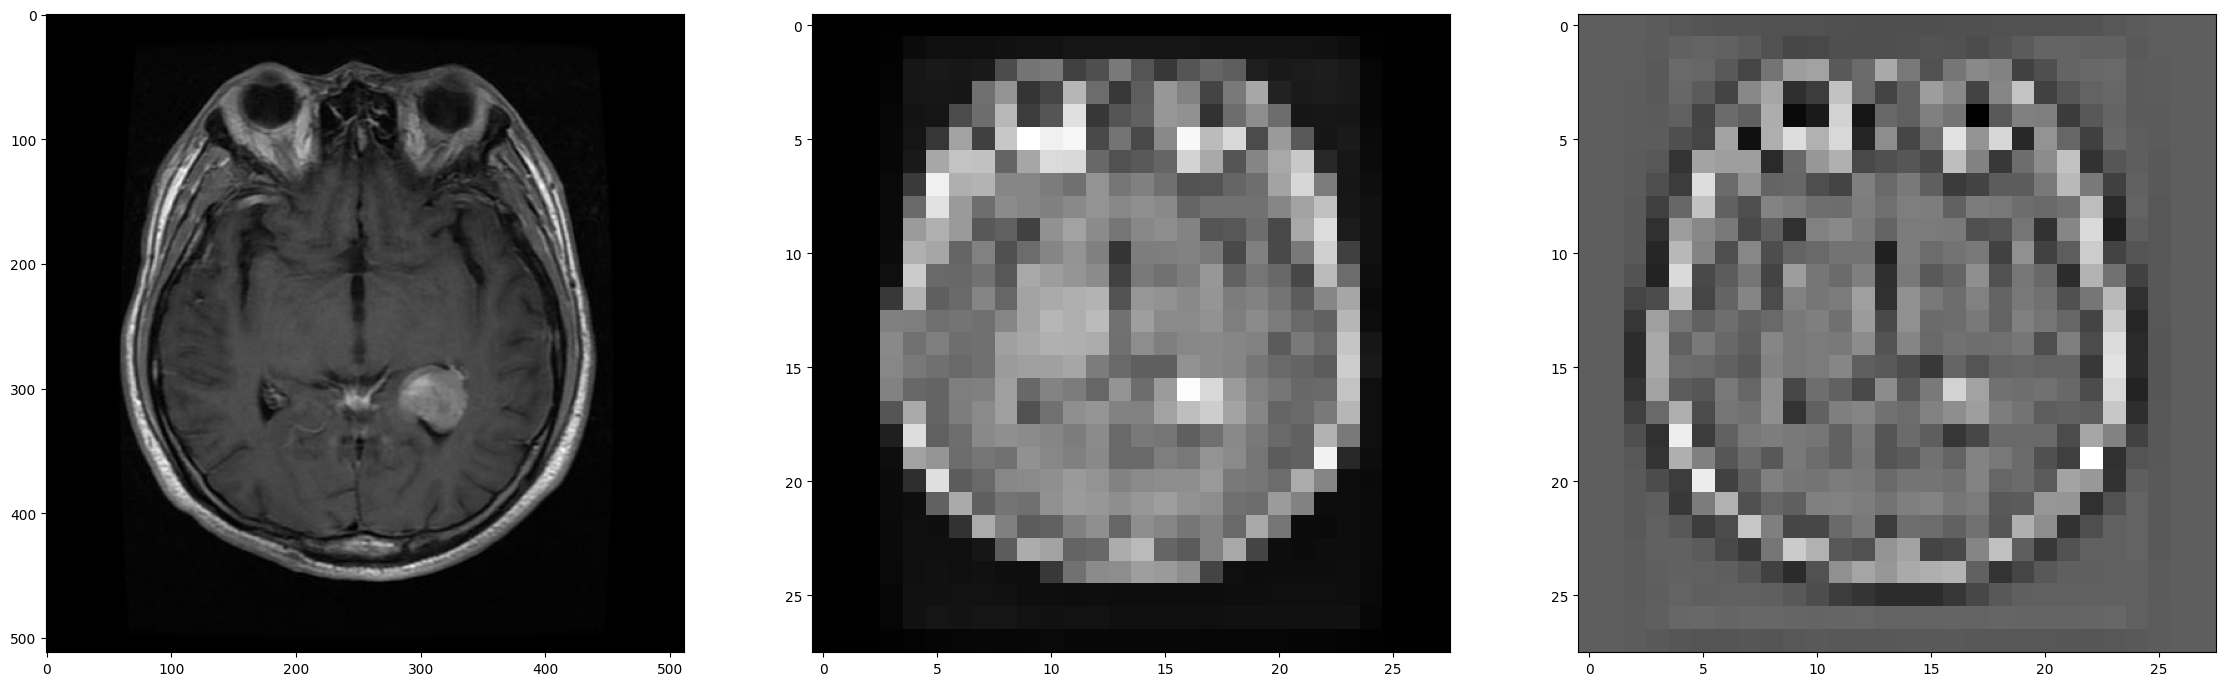

In [3]:
#image preprocessing
#try for an image
import cv2
img = cv2.imread("/content/drive/MyDrive/dataset/Training/meningioma/Tr-meTr_0001.jpg")
fig,ax = plt.subplots(1,3,figsize=(28,56))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ax[0].imshow(img,cmap="grey")
#contrast the image
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img = clahe.apply(img)
#resize the image an normalize it
img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)
img = img.astype(np.float32) / 255.0
ax[1].imshow(img,cmap="grey")
#sharpen the image
kernel = np.array([[-1, -1, -1],
                   [-1,  9, -1],
                   [-1, -1, -1]])
img = cv2.filter2D(img, -1, kernel)
#show the edited image
ax[2].imshow(img,cmap="grey")

In [4]:
import os
def prepare_minst_dataset(root_dir):
  x = []
  y = []
  classes = sorted(os.listdir(root_dir))
  for label, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            #contrast the image
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            img = clahe.apply(img)
            #resize the image an normalize it
            img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)
            img = img.astype(np.float32) / 255.0
            #sharpen the image
            kernel = np.array([[-1, -1, -1],
                   [-1,  9, -1],
                   [-1, -1, -1]])
            img = cv2.filter2D(img, -1, kernel)
            img = np.expand_dims(img, axis=0)
            x.append(img)
            y.append(label)
  x = np.array(x)
  y = np.array(y)
  x = torch.FloatTensor(x)
  y= torch.LongTensor(y)
  return x,y
#make minst dataset
x_train, y_train = prepare_minst_dataset("/content/drive/MyDrive/dataset/Training")
x_test, y_test = prepare_minst_dataset("/content/drive/MyDrive/dataset/Testing")
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(x_train,y_train)
test_dataset = TensorDataset(x_test,y_test)


In [5]:
#try convolution and pooling for one x
for x,y in train_dataset:
  break
x = x.view(1,1,28,28)
conn1 = nn.Conv2d(1,6,3,1)
conn2 = nn.Conv2d(6,16,3,1)
x = F.relu(conn1(x))
x = F.max_pool2d(x,2,2)
x = F.relu(conn2(x))
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 16, 5, 5])

In [6]:
#constructing convolutional neural network
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    self.fc1 = nn.Linear(5*5*16,480)
    self.fc2 = nn.Linear(480,240)
    self.fc3 = nn.Linear(240,120)
    self.fc4 = nn.Linear(120,84)
    self.fc5 = nn.Linear(84,4)
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)
    x = x.view(-1,16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = self.fc5(x)
    return F.log_softmax(x,dim=1)
torch.manual_seed(42)
model = CNN()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()


In [7]:
#training the model
epochs = 20
train_corr = []
losses = []
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
for i in range(epochs):
  count=0
  loss = 1
  for b,(x_train,y_train) in enumerate(train_loader):
    y_pred = model(x_train)
    loss = criterion(y_pred,y_train)
    predicted = torch.max(y_pred,1)[1]
    count += (y_train==predicted).sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  losses.append(loss)
  train_corr.append(count)
  if i%1==0:
    print("loss and correct",loss,count)



loss and correct tensor(0.5125, grad_fn=<NllLossBackward0>) tensor(3584)
loss and correct tensor(0.4954, grad_fn=<NllLossBackward0>) tensor(4413)
loss and correct tensor(0.2724, grad_fn=<NllLossBackward0>) tensor(4782)
loss and correct tensor(0.0860, grad_fn=<NllLossBackward0>) tensor(4987)
loss and correct tensor(0.6328, grad_fn=<NllLossBackward0>) tensor(5057)
loss and correct tensor(0.1719, grad_fn=<NllLossBackward0>) tensor(5184)
loss and correct tensor(0.4816, grad_fn=<NllLossBackward0>) tensor(5305)
loss and correct tensor(0.0811, grad_fn=<NllLossBackward0>) tensor(5372)
loss and correct tensor(0.2881, grad_fn=<NllLossBackward0>) tensor(5472)
loss and correct tensor(0.0635, grad_fn=<NllLossBackward0>) tensor(5489)
loss and correct tensor(0.0251, grad_fn=<NllLossBackward0>) tensor(5538)
loss and correct tensor(0.0273, grad_fn=<NllLossBackward0>) tensor(5479)
loss and correct tensor(0.0573, grad_fn=<NllLossBackward0>) tensor(5587)
loss and correct tensor(0.0211, grad_fn=<NllLossBac

In [8]:
#testing the model
from sklearn.metrics import classification_report
test_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
total = 0
predictions=0
y_test_validation = np.array([])
y_pred_validation = np.array([])
#convert tensor into 1d numpy array
for b,(x_test,y_test) in enumerate(test_loader):
  y_pred = model(x_test)
  predicted = torch.max(y_pred,1)[1].detach().numpy().flatten()
  test = y_test.detach().numpy().flatten()
  y_test_validation = np.concatenate([y_test_validation,test])
  y_pred_validation = np.concatenate([y_pred_validation,predicted])


In [9]:
print(classification_report(y_test_validation,y_pred_validation))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1321
         1.0       0.98      1.00      0.99      1339
         2.0       1.00      1.00      1.00      1595
         3.0       1.00      0.99      1.00      1457

    accuracy                           0.99      5712
   macro avg       0.99      0.99      0.99      5712
weighted avg       1.00      0.99      0.99      5712



In [15]:
#trying from an image ourside the dataset
#it is expected to be meningioma
labels = ["glioma","meningioma","no tumor","pituitary"]
img = cv2.imread("/content/Brain-tumor-dataset-a-no-tumor-and-b-brain-tumor.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#contrast the image
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img = clahe.apply(img)
#resize the image an normalize it
img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)
img = img.astype(np.float32) / 255.0
#sharpen the image
kernel = np.array([[-1, -1, -1],
                   [-1,  9, -1],
                   [-1, -1, -1]])
img = cv2.filter2D(img, -1, kernel)
img = np.expand_dims(img, axis=0)
image = []
image.append(img)
image = np.array(img)
image = torch.FloatTensor(image)
value = model(image)
value = value.argmax()
print(labels[value])

no tumor
